In [182]:
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn import metrics
import shap
import matplotlib.pyplot as plt
import seaborn as sns


In [420]:
gameweek_df = pd.read_csv('data/processed/combined_gameweeks.csv',parse_dates=['date'])

Columns (25,57,58) have mixed types.Specify dtype option on import or set low_memory=False.


In [421]:
gameweek_df.groupby('season')['name'].first()

season
2018-19    Aaron_Cresswell_402
2019-20    Aaron_Cresswell_376
2020-21         Aaron Connolly
2021-22            Eric Bailly
Name: name, dtype: object

In [422]:
def clean_name(name_series):
    split = name_series.str.replace("\_\d+","",regex=True).str.replace("_"," ", regex=False).str.split()
    return split.str[0] + '_' +  split.str[-1]

In [423]:
gameweek_df['clean_name'] = clean_name(gameweek_df.name)

In [424]:
understat_df = pd.read_csv('data/processed/understat_raw.csv',parse_dates=['date'])

In [425]:
understat_df.date

0       2021-11-20
1       2021-11-06
2       2021-10-31
3       2021-10-23
4       2021-10-16
           ...    
61002   2014-10-04
61003   2014-09-29
61004   2014-09-20
61005   2014-08-23
61006   2014-08-17
Name: date, Length: 61007, dtype: datetime64[ns]

In [426]:
understat_df['clean_name'] = understat_df.player.str.replace('\_\d+\.csv','',regex=True)

In [616]:
understat_df['xC'] = understat_df.xG + understat_df.xA

In [427]:
gameweek_df['has_understat'] = gameweek_df['clean_name'].isin(understat_df.clean_name)

In [428]:
gameweek_df.groupby('season')['has_understat'].mean()

season
2018-19    0.451813
2019-20    0.555569
2020-21    0.680648
2021-22    0.711701
Name: has_understat, dtype: float64

In [429]:
gameweek_df['weighted_us'] = gameweek_df.minutes * gameweek_df.has_understat

In [430]:
gameweek_df.groupby('season')['weighted_us'].sum() /  gameweek_df.groupby('season')['minutes'].sum()

season
2018-19    0.595154
2019-20    0.713867
2020-21    0.855324
2021-22    0.829458
dtype: float64

I'm sure I can go further but this is a good start :)

In [431]:
gameweek_df.loc[~gameweek_df.has_understat & (gameweek_df.season == '2021-22'),'clean_name']

62713    Ayotomiwa_Dele-Bashiru
62716           Adrián_Castillo
62718               Kwadwo_Baah
62721           Alexis_Allister
62724             José_Teixeira
                  ...          
69935             Jordan_Hugill
69940                 Owen_Beck
69943              N'Golo_Kanté
69944               Josh_Martin
69948               Mathew_Ryan
Name: clean_name, Length: 2087, dtype: object

In [617]:
UNDERSTAT_COLS = ['xG',
 'xA', 
 'npg', 'npxG', 'xGChain', 'xGBuildup','xC'
]

In [618]:
with_understat = gameweek_df.merge(understat_df[ UNDERSTAT_COLS + ['clean_name','date']],
                  how='left',
                  on=['clean_name','date'],suffixes=('','_u'))
with_xg_data = with_understat.loc[with_understat.xG.notna()]
num = with_xg_data.loc[with_xg_data.xG.notna()].groupby('season')['clean_name'].count() 

denom = gameweek_df.loc[gameweek_df.minutes > 0].groupby('season')['clean_name'].count()
num /denom

season
2018-19    0.578340
2019-20    0.700975
2020-21    0.854325
2021-22    0.833937
Name: clean_name, dtype: float64

I'll work with this for now :) 

In [619]:
## can we help the model by showing the relationship between gk/defence and conceded?

In [651]:
with_understat[UNDERSTAT_COLS] = with_understat[UNDERSTAT_COLS].fillna(0)

In [652]:
combined_df = gameweek_df

In [653]:
combined_df.position = combined_df.groupby('clean_name')['position'].bfill()

In [654]:
combined_df['defensive_cleansheet'] = combined_df.clean_sheets & combined_df.position.isin(['DEF','MID'])

In [655]:
combined_df['defensive_goals_conceded'] = combined_df['goals_conceded'] 

In [656]:
combined_df.loc[~combined_df.position.isin(['DEF','MID']),['defensive_cleansheet',
                                                          'defensive_goals_conceded']] = np.nan

In [657]:
def add_moving_average(df, ma_columns, name_col,pref='ma4_', half_life=4):
    df = df.sort_values(by=[name_col, "season", "gw"]).reset_index(drop=True)
    ma_columns_output = [pref + c for c in ma_columns]
    df[ma_columns_output] = df.groupby(name_col)[ma_columns].apply(
        lambda x: x.ewm(halflife=half_life).mean()
    ).reset_index(drop=True)
    df[ma_columns_output] = df.groupby(name_col)[ma_columns_output].shift(1)
    return df

In [658]:
MA_COLS = [
    'assists', 'attempted_passes', 'big_chances_created',
       'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
       'clearances_blocks_interceptions', 'completed_passes', 'creativity',
       'dribbles', 'ea_index', 'errors_leading_to_goal',
       'errors_leading_to_goal_attempt', 'fouls', 'goals_conceded',
       'goals_scored', 'influence', 'key_passes',
        'loaned_in', 'loaned_out',
       'minutes', 'offside', 'open_play_crosses', 'opponent_team', 'own_goals',
       'penalties_conceded', 'penalties_missed', 'penalties_saved',
       'recoveries', 'red_cards', 'saves', 'selected', 'tackled',
       'tackles', 'target_missed', 'team_a_score', 'team_h_score', 'threat',
        'winning_goals', 'yellow_cards','total_points',
    'ict_index','xP','defensive_cleansheet','defensive_goals_conceded'
            ] #+ UNDERSTAT_COLS 

In [659]:
EXCLUDE_COLS = ['name','clean_name','element','id',
               'id', 'kickoff_time',
       'kickoff_time_formatted', 'round','fixture', 'date','weighted_us', 'has_understat'] + MA_COLS 

In [660]:
combined_df['prev_selected'] = combined_df.groupby('clean_name')['selected'].shift(1)

In [661]:
combined_df.total_points =pd.to_numeric(combined_df.total_points)

In [662]:
cat_cols = combined_df.select_dtypes('O').columns
combined_df[cat_cols] = combined_df[cat_cols].astype('category')

In [695]:
HL = 15
with_ma = add_moving_average(combined_df, MA_COLS,'clean_name',pref=f'ma_{HL}_', half_life=HL)

In [696]:
train = with_ma[with_ma.season != '2021-22']
test = with_ma[with_ma.season == '2021-22']

In [745]:
X_train, X_test = train.drop(columns = EXCLUDE_COLS), test.drop(columns=EXCLUDE_COLS)
y_train, y_test = train.total_points, test.total_points                 
w_train, w_test = train.selected, test.selected

In [698]:
reg = lgb.LGBMRegressor()

In [699]:
reg.fit(X_train,y_train,sample_weight=w_train)

LGBMRegressor()

In [700]:
y_pred = reg.predict(X_test)

In [701]:
y_dummy = np.repeat(y_train.mean(), len(X_test))

In [702]:
metrics.mean_squared_error(y_pred,y_test,sample_weight=w_test)

13.126574601098044

In [703]:
metrics.mean_squared_error(y_dummy,y_test,sample_weight=w_test)

19.220645412226766

In [723]:
def create_shaps(X,y,reg):
    explainer = shap.TreeExplainer(reg)
    shap_values = explainer.shap_values(X)
    # rank features by importance - average abs. shap value
    importance_shap = np.abs(shap_values).mean(axis=0)
    ranked_features = sorted(
        list(zip(X.columns, importance_shap)), key=lambda x: -x[1]
    )  # sorted by importance (descending)
    features_df = pd.DataFrame(ranked_features, columns=["feature", "importance"])
    features_df["% total importance"] = (
        features_df.importance / features_df.importance.sum()
    ) * 100
    ax = sns.barplot(data=features_df.head(20), y="feature", x="% total importance")
    plt.title("Top 20 features \n % Average abs. Shap value importance (% total)")
    plt.show()
    ax = shap.summary_plot(
        shap_values,
        X,
    )
    plt.show()
    X_plot = X.copy()
    for col in X.select_dtypes("category").columns:
        X_plot[col] = X[col].cat.codes
    for feat in ranked_features[:10]:
        ax = shap.dependence_plot(
        ind=feat[0],
        shap_values=shap_values,
        features=X_plot,
        display_features=X,
        )
        plt.show()

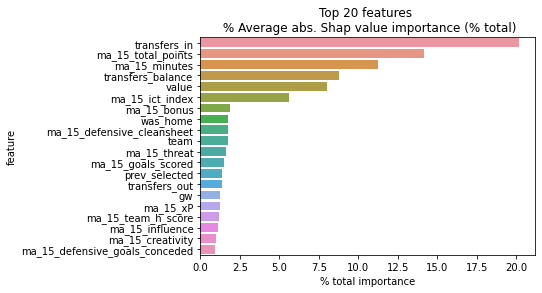

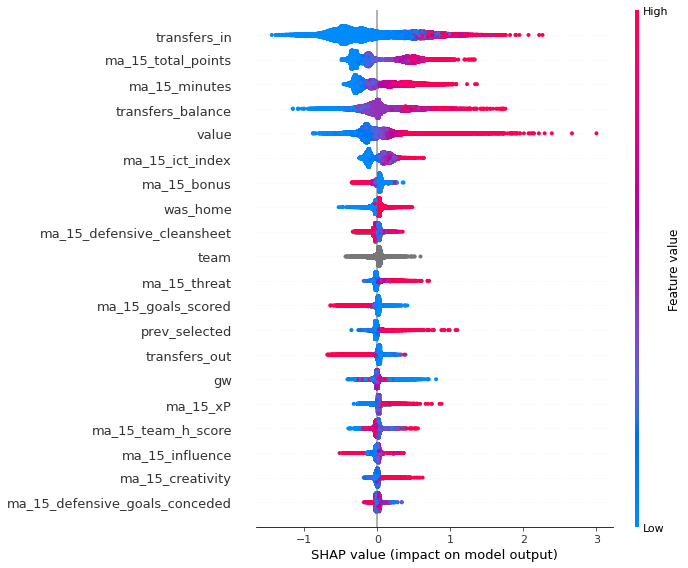

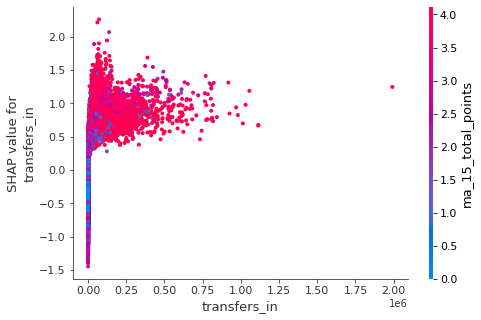

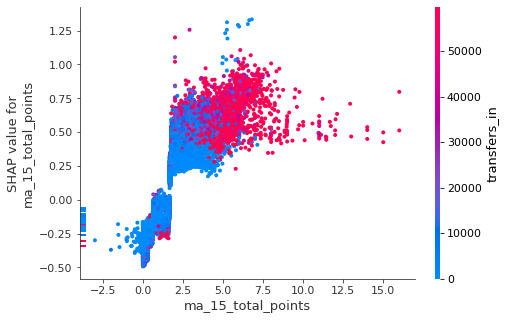

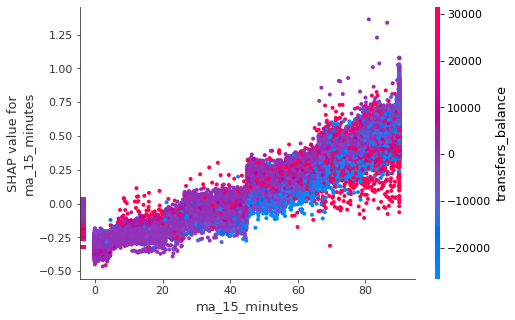

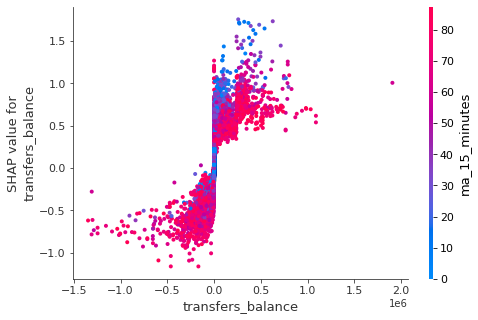

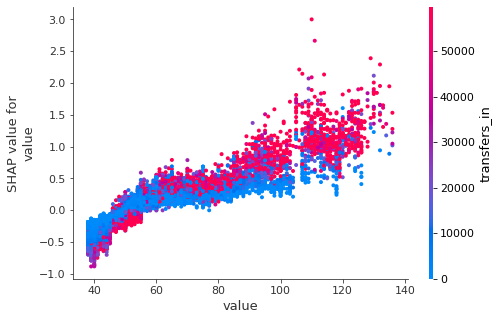

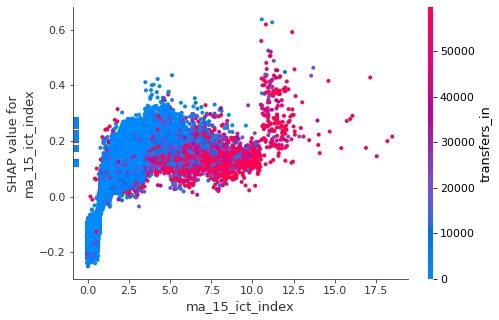

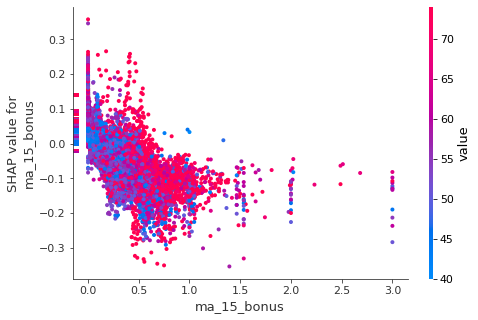

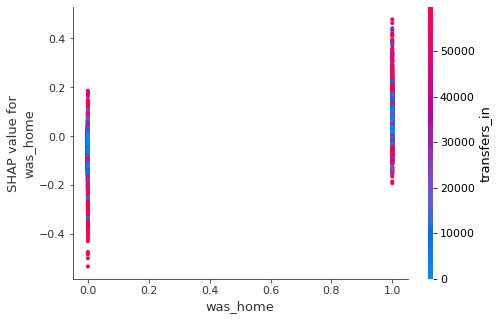

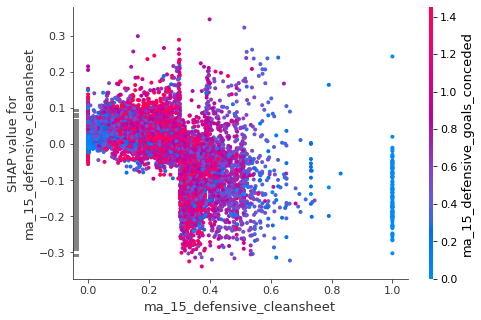

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


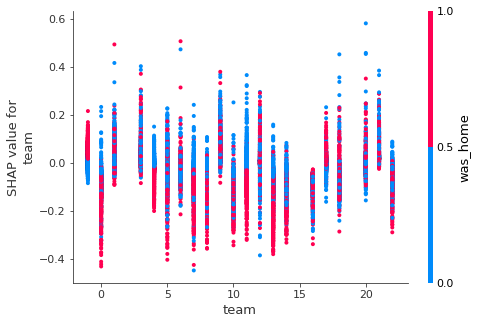

In [724]:
create_shaps(X_train,y_train,reg)

In [716]:
X = X_train.append(X_test)

In [718]:
y = y_train.append(y_test)

In [725]:
reg_2 = lgb.LGBMRegressor()

In [732]:
reg_2.fit(X,y,with_ma.selected)

LGBMRegressor()

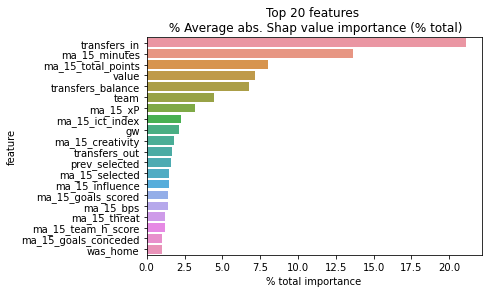

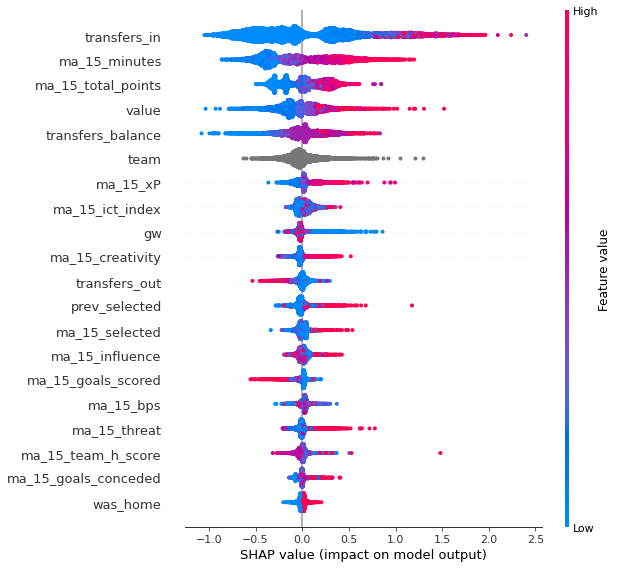

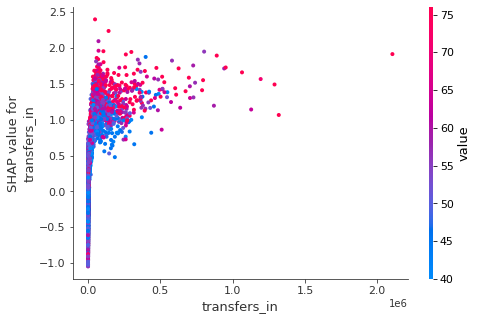

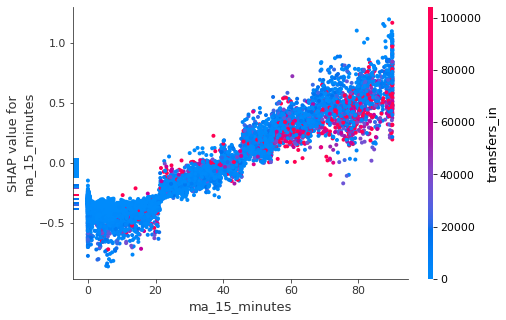

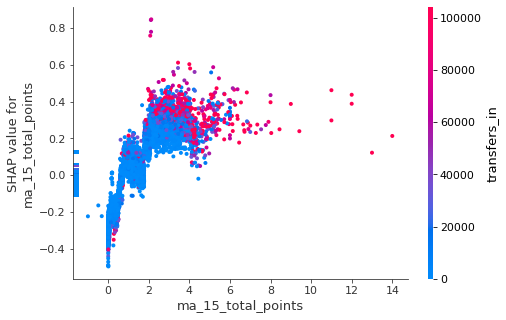

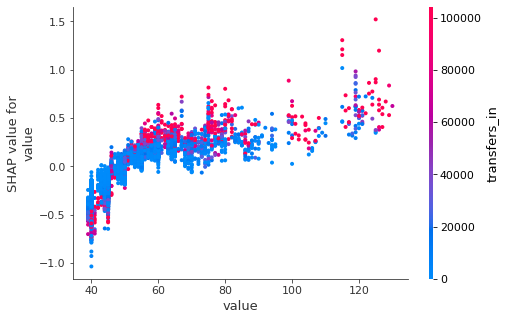

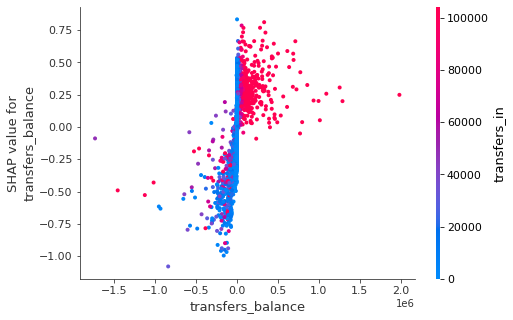

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


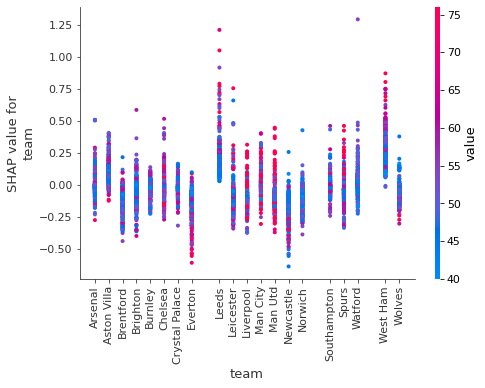

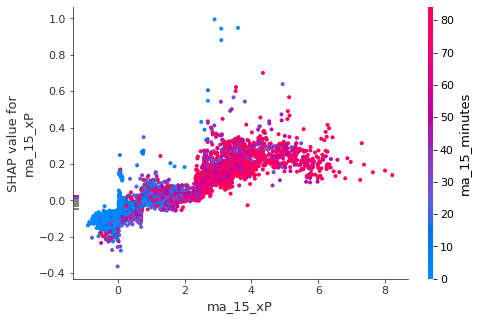

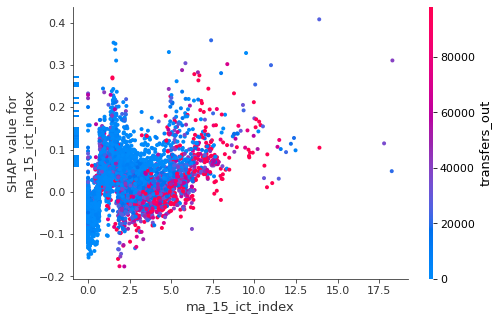

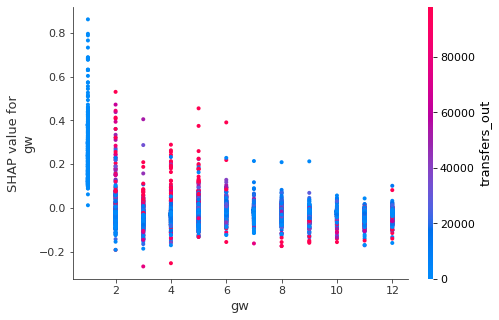

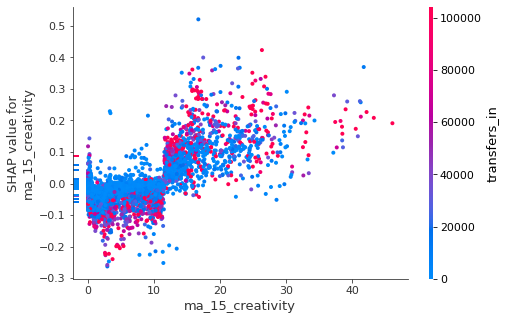

In [733]:
create_shaps(X_test,y_test,reg_2)

In [746]:
#a little leaky
_X_test = X_test.copy()
_X_test['pred'] = reg_2.predict(X_test)
_X_test['name'] = test.clean_name

<AxesSubplot:ylabel='name'>

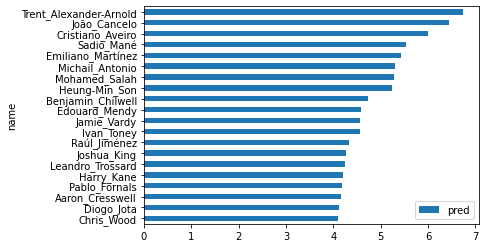

In [760]:
_X_test.drop_duplicates(subset=['name'],keep='last')[['name','pred']].set_index('name').sort_values(by='pred').tail(20).plot.barh()

In [761]:
# lol I think this pretty rubbish to have Salah so low although this is quite a lot of my watchlist :) 